<a href="https://colab.research.google.com/github/rmokashi82/Coursera_Capstone2/blob/master/IBM_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="color:blue">IBM Data Science Capstone </h1>
    <h3>This Notebook contains the Final Assignment of the IBM Capstone - The Battle of the Neighborhood.</h3>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Ahmedabad Geospatial Dataset

In [2]:
vicinity_df = pd.read_csv('Abad_lat_lng_upd.csv')
vicinity_df[vicinity_df.isnull().any(axis=1)]

,Vicinity,V Lat,V Long
46,Lapkaman,NaN,NaN
51,Goraj,NaN,NaN
52,Kundal,NaN,NaN
54,Fangadi,NaN,NaN
55,Vekaria,NaN,NaN
...,...,...,...
444,Fatepur,NaN,NaN
449,Panchham,NaN,NaN
450,Buranpur,NaN,NaN
455,Digvijaynagar,NaN,NaN


#### Drop Records That Do Not Have Geo Data

In [3]:
#drop rows with NaN values
vicinity_df.dropna(axis=0, inplace=True)
vicinity_df

,Vicinity,V Lat,V Long
0,Lal Darwaja,23.024190,72.578556
1,Manek Chowk,23.023180,72.588952
2,Shahibag,23.055966,72.593869
3,Sabarmati,23.083993,72.587619
4,Kabir Chowk,23.087505,72.585701
...,...,...,...
457,Sardarnagar,23.083583,72.624861
458,Ranip,23.076623,72.576420
459,Gota,23.073910,72.557217
460,Chandlodia,23.084580,72.567884


#### Select First 50 Neighborhood

In [4]:
vicinity_df = vicinity_df.head(50).reset_index()
vicinity_df.drop(['index'], axis=1, inplace=True)
vicinity_df

,Vicinity,V Lat,V Long
0,Lal Darwaja,23.024190,72.578556
1,Manek Chowk,23.023180,72.588952
2,Shahibag,23.055966,72.593869
3,Sabarmati,23.083993,72.587619
4,Kabir Chowk,23.087505,72.585701
5,Motera,23.091703,72.597481
6,Ambawadi (Ahmedabad),23.022612,72.549083
7,Ellisbridge,23.022886,72.571642
8,Paldi (Ahmedabad),23.014553,72.563543
9,Sarkhej Road,22.983483,72.500720


## Get Nearby Places Using Foursquare Location Services API

#### Define Foursquare Credentials

In [5]:
#@title
CLIENT_ID = 'M4GPEZEOTPJDP5YFT5ZQRDNJHGLQDVMOR2LO52IO51OKT5PZ' # Foursquare ID
CLIENT_SECRET = 'JYKIKLICQYHXOFDO3ZLMJ3D3ZG0KLULMOMG0TRF4J5JUEGUA' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails Defined:')

Credentails Defined:


#### Define Function to Search The Neighborhood With Keyword 'Pizza'

In [6]:
def searchVenues(names, latitudes, longitudes, radius=1100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=pizza'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
              category = v['categories'][0]['name']
            except:
              category = 'Pizza Place'
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['id'],
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                category,
                v['location']['distance'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',           
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Distance']
    
    return(nearby_venues)

#### Get Venues for Each Neighborhood

In [7]:
ahmedabad_venues = searchVenues(
                                     names = vicinity_df['Vicinity'],
                                     latitudes = vicinity_df['V Lat'],
                                     longitudes = vicinity_df['V Long'],
                                 )
ahmedabad_venues.head()

Lal Darwaja
Manek Chowk
Shahibag
Sabarmati
Kabir Chowk
Motera
Ambawadi (Ahmedabad)
Ellisbridge
Paldi (Ahmedabad)
Sarkhej Road
Anandnagar (Ahmedabad)
Shardanagar
Narayannagar
Jawahar Chowk
Maninagar
Ashram Road
Darpan Society
Gujarat University
Navrangpura
Stadium Marg
Vadaj
Naranpura Vistar
Shastrinagar (Ahmedabad)
Nava Vadaj
Navjivan
Jodhpur Char Rasta
I I M
Manekbag
Polytechnic (Ahmedabad)
Azad Society
Meghaningar
Gita Mandir Road
Civil Hospital
Gandhi Ashram (Ahmedabad)
Jivraj Park
Memnagar
Thaltej Road
Bodakdev
Juhapura
Bopal
Ghuma
Ambli
Shela
Thaltej
Shilaj
Sola
Bhadaj
Ognaj
Ghatlodia
Sola H B C


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
0,Lal Darwaja,23.02419,72.578556,56fcee27498eef4f589db68f,Pizza Hut,23.032067,72.570223,Pizza Place,1223
1,Lal Darwaja,23.02419,72.578556,510947c5e4b0c06b6e9fe820,Chef's Pizza,23.026209,72.580739,Pizza Place,317
2,Lal Darwaja,23.02419,72.578556,5300f3f9498efe1cdbdcc2e0,Pizza Hut Delivery Express,23.031657,72.570516,Pizza Place,1170
3,Lal Darwaja,23.02419,72.578556,51d31558498eab154179e566,Manek Pizza & Sandwich,23.023835,72.588502,Fast Food Restaurant,1019
4,Lal Darwaja,23.02419,72.578556,4fd73e73e4b0ed2ec945faa6,Pinky Pizza,23.027697,72.589634,Fast Food Restaurant,1200


In [8]:
print(ahmedabad_venues.shape[0])
ahmedabad_venues.sort_values(by=['Venue ID','Distance'], ascending=True, inplace=True)
ahmedabad_venues.head()

256


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
153,Jodhpur Char Rasta,23.025341,72.527761,4bace359f964a52011163be3,Pizza hut,23.026240,72.529440,Italian Restaurant,199
183,Azad Society,23.029157,72.532752,4bace359f964a52011163be3,Pizza hut,23.026240,72.529440,Italian Restaurant,469
158,I I M,23.031270,72.537133,4bace359f964a52011163be3,Pizza hut,23.026240,72.529440,Italian Restaurant,966
51,Anandnagar (Ahmedabad),23.016075,72.509295,4bc829dd14d79521b49c68e9,Domino's Pizza,23.024285,72.507111,Pizza Place,940
42,Anandnagar (Ahmedabad),23.016075,72.509295,4bd6e2decfa7b7132e3428da,Jasuben pizza,23.015231,72.507146,Pizza Place,239


In [9]:
ahmedabad_venues[ahmedabad_venues['Venue']=='bon pizza']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
157,I I M,23.031270,72.537133,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,499
181,Polytechnic (Ahmedabad),23.026577,72.547506,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,701
113,Gujarat University,23.037307,72.544748,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,855
189,Azad Society,23.029157,72.532752,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,936
24,Ambawadi (Ahmedabad),23.022612,72.549083,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,1116
173,Manekbag,23.019342,72.541232,541d99c5498e3fbc999faec7,bon pizza,23.030107,72.54184,Pizza Place,1200


#### Remove Duplicate Pizza Places Intersecting the Radii of Neighborhoods

In [10]:
duplicates = pd.DataFrame(ahmedabad_venues.groupby(['Venue ID', 'Venue']).count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
duplicates.head()

,,Neighborhood
Venue ID,Venue,
4f5ccb33e4b05cfda5d7cbad,Domino's Pizza,6
561d52eb498ed81f498c4fbe,Domino's Pizza,6
541d99c5498e3fbc999faec7,bon pizza,6
5162ba38e4b03d1defd89f4f,Jasuben old pizza,5
56fcee25498ee94f64c5b967,Pizza Hut,5


In [11]:
ahmedabad_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)
print(ahmedabad_venues.shape[0])
print(ahmedabad_venues['Neighborhood'].unique())
duplicates = pd.DataFrame(ahmedabad_venues.groupby(['Venue ID', 'Venue']).count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
duplicates.head()

120
['Jodhpur Char Rasta' 'Anandnagar (Ahmedabad)' 'Ambawadi (Ahmedabad)'
 'Memnagar' 'Navrangpura' 'Maninagar' 'Bodakdev'
 'Shastrinagar (Ahmedabad)' 'Azad Society' 'Narayannagar'
 'Gujarat University' 'Bopal' 'Shardanagar' 'Gandhi Ashram (Ahmedabad)'
 'I I M' 'Darpan Society' 'Polytechnic (Ahmedabad)' 'Ghatlodia'
 'Manek Chowk' 'Motera' 'Jawahar Chowk' 'Paldi (Ahmedabad)' 'Shahibag'
 'Lal Darwaja' 'Ashram Road' 'Manekbag' 'Stadium Marg' 'Thaltej'
 'Gita Mandir Road' 'Ghuma' 'Juhapura' 'Thaltej Road']


,,Neighborhood
Venue ID,Venue,
4bace359f964a52011163be3,Pizza hut,1
4bc829dd14d79521b49c68e9,Domino's Pizza,1
5319778a498e2932f30def4b,Neopolitan Pizza,1
530e081011d20a35828c5200,Pizza Hut,1
5300f3f9498efe1cdbdcc2e0,Pizza Hut Delivery Express,1


### Check if Multiple Branches Are Classified Into Different Venue Categories

In [12]:
branches_df = pd.DataFrame(ahmedabad_venues.groupby(['Venue']).count().sort_values(by='Neighborhood', ascending=False)['Neighborhood'])
branches_df.reset_index(inplace=True)
branches_df.rename(columns={'Neighborhood':'Count'}, inplace=True)
branches_df.head(15)

,Venue,Count
0,Domino's Pizza,18
1,Pizza Hut,9
2,U S Pizza,6
3,Pizza Zone,3
4,La Pino's Pizza,2
5,Pizza World,2
6,Enjoy Pizza,2
7,Sam's Pizza,2
8,Pizza Americano,2
9,Pomos Pizza,1


In [13]:
temp_df = ahmedabad_venues.groupby(['Venue', 'Venue Category']).count()
temp_df.reset_index(inplace=True)
cols = ['Venue','Category List']

multi_cat = []
for branch in range(len(branches_df)): 
    lst = []
    lst = temp_df.loc[temp_df['Venue'].str.contains(temp_df.loc[branch]['Venue'], case=False)]['Venue Category'].unique()
    if len(lst) > 1:
        multi_cat.append([temp_df.loc[branch]['Venue'], lst])
multi_cat = pd.DataFrame(multi_cat, columns=cols)
multi_cat.drop_duplicates(subset=['Venue'], keep='last', inplace=True)
multi_cat.reset_index(inplace=True)
multi_cat.drop('index', inplace=True, axis=1)

In [14]:
multi_cat

,Venue,Category List
0,Bon pizza,"[Food Truck, Pizza Place]"
1,Enjoy Pizza,"[Italian Restaurant, Pizza Place]"
2,Pizza Hut,"[Pizza Place, Italian Restaurant]"
3,Pizza hut,"[Pizza Place, Italian Restaurant]"
4,U S Pizza,"[Italian Restaurant, Pizza Place]"
5,U.S Pizza,"[Italian Restaurant, Pizza Place]"
6,U.S.Pizza,"[Italian Restaurant, Pizza Place]"
7,bon pizza,"[Food Truck, Pizza Place]"


#### Classify Each of the Branches Identified Above Into Uniform Category

In [15]:
for v in range(len(multi_cat)):
  ahmedabad_venues.loc[ahmedabad_venues['Venue'].str.contains(multi_cat.loc[v, 'Venue'], case=False), 'Venue Category'] = 'Pizza Place'

#### Check various other categories that also serves pizzas

In [16]:
ahmedabad_venues['Venue Category'].unique()

array(['Pizza Place', 'Arcade', 'Asian Restaurant', 'Sandwich Place',
       'Fast Food Restaurant', 'Italian Restaurant', 'Food Truck'],
      dtype=object)

#### Check out the places classified as Italian Restaurant

In [17]:
ahmedabad_venues[ahmedabad_venues['Venue Category']== 'Italian Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
78,Maninagar,22.997713,72.606717,5219ce4111d27a09b610db33,Italiano Pizza,23.001574,72.603958,Italian Restaurant,514
49,Anandnagar (Ahmedabad),23.016075,72.509295,55a7464b498e5be6be14f99c,Pizza shop test,23.006515,72.506740,Italian Restaurant,1095
93,Darpan Society,23.046712,72.553567,58e11ad50acb6a21e3503442,Madro's Pizza,23.043184,72.550020,Italian Restaurant,535


The above places classified as Italian Restaurants can be classified as a Pizza Place

In [18]:
ahmedabad_venues['Venue Category'] = ahmedabad_venues['Venue Category'].replace(['Italian Restaurant'],['Pizza Place'])
ahmedabad_venues['Venue Category'].unique()

array(['Pizza Place', 'Arcade', 'Asian Restaurant', 'Sandwich Place',
       'Fast Food Restaurant', 'Food Truck'], dtype=object)

#### Check out the places classified as Asian Restaurant

In [19]:
ahmedabad_venues[ahmedabad_venues['Venue Category']== 'Asian Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
67,Narayannagar,22.997826,72.560115,4e0f3266d4c0f6d6b4014bfa,Pizzaiolo,23.003846,72.558785,Asian Restaurant,683


The above place classified as Asian Restaurant can be classified as a Pizza Place

In [20]:
ahmedabad_venues['Venue Category'] = ahmedabad_venues['Venue Category'].replace(['Asian Restaurant'],['Pizza Place'])
ahmedabad_venues['Venue Category'].unique()

array(['Pizza Place', 'Arcade', 'Sandwich Place', 'Fast Food Restaurant',
       'Food Truck'], dtype=object)

#### Check the Rest of The Categories

In [21]:
ahmedabad_venues[ahmedabad_venues['Venue Category'].isin(['Fast Food Restaurant', 'Sandwich Place', 'Food Truck', 'Arcade'])]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
147,Shastrinagar (Ahmedabad),23.062423,72.553180,4d033bf0e8d85941b2dc2ca6,"pizza , 36 types of salad",23.061747,72.553174,Arcade,75
236,Bopal,23.029699,72.465579,4f770248e4b042108253cc98,Amul Sandwich & Pizza,23.029089,72.477398,Sandwich Place,1212
9,Manek Chowk,23.023180,72.588952,4fd73e73e4b0ed2ec945faa6,Pinky Pizza,23.027697,72.589634,Fast Food Restaurant,507
205,Memnagar,23.053084,72.532931,50e5b0b9e4b08bda3081f822,Amul Sandwich And Pizza,23.046270,72.530069,Sandwich Place,813
57,Shardanagar,23.011190,72.552575,513a0b59e4b0a4dac98fd3fb,Modi Sandwich & Pizza,23.006339,72.556463,Fast Food Restaurant,670
86,Ashram Road,23.026694,72.571078,5162ba38e4b03d1defd89f4f,Jasuben old pizza,23.025290,72.560610,Fast Food Restaurant,1083
12,Manek Chowk,23.023180,72.588952,51b22415498efb02c2f3e348,Shakti Parlour,23.026856,72.588710,Sandwich Place,410
8,Manek Chowk,23.023180,72.588952,51c43efd498ec4d1ef2a0422,Amrut Sandwich & Pizza,23.021963,72.589807,Sandwich Place,161
7,Manek Chowk,23.023180,72.588952,51d31558498eab154179e566,Manek Pizza & Sandwich,23.023835,72.588502,Fast Food Restaurant,86
58,Shardanagar,23.011190,72.552575,52adbc8511d283579275dcec,Aman Pizza and Sandwich,23.005728,72.555486,Sandwich Place,677


Classify the rest of the categories into Pizza Place

In [22]:
ahmedabad_venues['Venue Category'] = ahmedabad_venues['Venue Category'].replace(['Fast Food Restaurant', 'Sandwich Place', 'Food Truck', 'Arcade'],'Pizza Place')
ahmedabad_venues['Venue Category'].unique()

array(['Pizza Place'], dtype=object)

### Plot Neighborhood Wise Count Of Pizza Places That Serve Some Kind Of Pizza

In [23]:
neighborhood_count = pd.DataFrame(ahmedabad_venues.groupby('Neighborhood').count()['Venue'])
neighborhood_count.sort_values(by='Venue', ascending=False, inplace=True)
neighborhood_count.reset_index(inplace=True)
neighborhood_count

,Neighborhood,Venue
0,Bodakdev,14
1,Anandnagar (Ahmedabad),13
2,Memnagar,12
3,Navrangpura,8
4,Darpan Society,6
5,Gujarat University,6
6,Maninagar,5
7,Shastrinagar (Ahmedabad),5
8,Manek Chowk,4
9,Shahibag,3


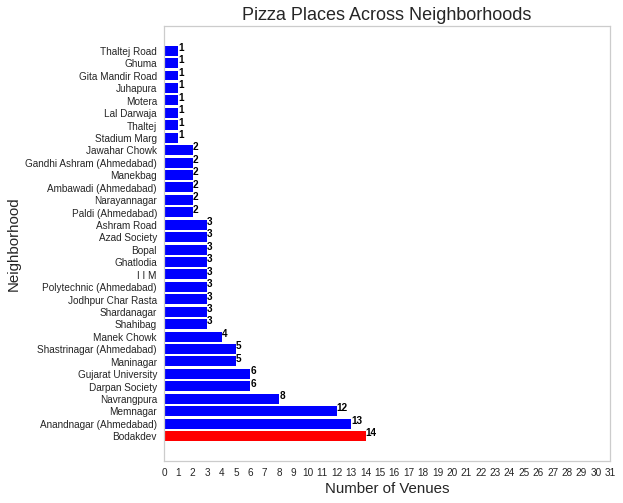

In [24]:
y_pos = [i for i, _ in enumerate(neighborhood_count.iloc[:,0].values)]
x_pos = [i for i, _ in enumerate(neighborhood_count.iloc[:,-1].values)]

maxval = neighborhood_count['Venue'].max()

colors = []
for value in neighborhood_count.iloc[:,-1].values:
    if value == maxval:
        colors.append('red')
    else:
        colors.append('blue')

plt.rcParams.update({'font.size': 10})
f, ax = plt.subplots(figsize=(8,8))
plt.barh(y_pos, neighborhood_count.iloc[:,-1].values, color=colors)
plt.title('Pizza Places Across Neighborhoods', fontsize=18)
plt.xlabel('Number of Venues', fontsize=15)
plt.ylabel('Neighborhood', fontsize=15)
plt.yticks(y_pos, neighborhood_count.iloc[:,0].values, fontsize=10)
plt.xticks(x_pos, fontsize=10)
plt.grid(b=None)

for i, v in enumerate(neighborhood_count.iloc[:,-1].values):
  ax.text(v, i, str(v), color='black', fontweight='bold')

plt.show()

In [25]:
# ahmedabad_df = vicinity_df.merge(ahmedabad_venues, how='outer', left_on='Vicinity', right_on='Neighborhood')
# ahmedabad_df.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], axis=1, inplace=True)
# ahmedabad_df.rename(columns={'Vicinity':'Neighborhood', 'V Lat':'Neighborhood Latitude', 'V Long':'Neighborhood Longitude'}, inplace=True)
# ahmedabad_df.fillna(0)

### Combine Data For All the Neighborhoods

In [26]:
no_pizzapl = []
cols = ['Neighborhood','Venue']
for v in range(len(vicinity_df)):
  # print(vicinity_df.loc[v, 'Vicinity'])
  if neighborhood_count[neighborhood_count['Neighborhood']==vicinity_df.loc[v, 'Vicinity']]['Venue'].any() == False:
    no_pizzapl.append([vicinity_df.loc[v, 'Vicinity'],0])
no_pizzapl_df = pd.DataFrame(no_pizzapl, columns=cols)
all_neighbors_df = neighborhood_count.append(no_pizzapl_df, ignore_index=True)
all_neighbors_df

,Neighborhood,Venue
0,Bodakdev,14
1,Anandnagar (Ahmedabad),13
2,Memnagar,12
3,Navrangpura,8
4,Darpan Society,6
5,Gujarat University,6
6,Maninagar,5
7,Shastrinagar (Ahmedabad),5
8,Manek Chowk,4
9,Shahibag,3


### Clustering Neighborhoods Using K-Means Method

#### Finding The Correct Value of K

49.999999999999986
14.543113238157039
5.264303482587064
1.7701456659012622
1.1500533049040509
0.6836353944562898
0.36380597014925375
0.22388059701492533
0.10883084577114428
0.04664179104477613


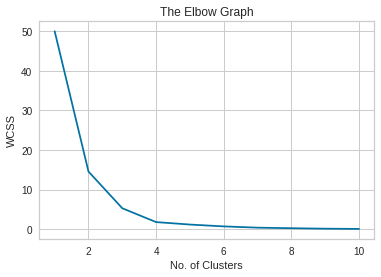

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f06ad767780>,
                 k=None, metric=None, model=None, timings=True)

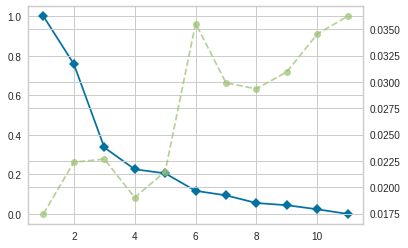

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

wcss = []
X = all_neighbors_df.drop('Neighborhood', axis=1)

# Apply Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Select clusters ranging from 1-10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=4)
    kmeans.fit(X)
    print(kmeans.inertia_)
    wcss.append(kmeans.inertia_)
# End of for loop and start of plotting
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Graph')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.show()

# Instantiate the clustering model and visualizer
model = KMeans(random_state=4)
visualizer = KElbowVisualizer(model, k=(1,12), metric='distortion', locate_elbow=True)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer


#### Based On The Above Elbow Graph, Let's Select K=4

In [28]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

#### Add Cluster Labels To Neighborhood Location Data

In [29]:
geo_df = vicinity_df.merge(all_neighbors_df, how='inner', left_on='Vicinity', right_on='Neighborhood')
geo_df.drop('Vicinity', axis=1, inplace=True)

# add clustering labels
geo_df.insert(3, 'Cluster Labels', kmeans.labels_)
geo_df


,V Lat,V Long,Neighborhood,Cluster Labels,Venue
0,23.024190,72.578556,Lal Darwaja,1,1
1,23.023180,72.588952,Manek Chowk,1,4
2,23.055966,72.593869,Shahibag,1,3
3,23.083993,72.587619,Sabarmati,3,0
4,23.087505,72.585701,Kabir Chowk,3,0
5,23.091703,72.597481,Motera,3,1
6,23.022612,72.549083,Ambawadi (Ahmedabad),3,2
7,23.022886,72.571642,Ellisbridge,3,0
8,23.014553,72.563543,Paldi (Ahmedabad),2,2
9,22.983483,72.500720,Sarkhej Road,2,0


### Map The Clusters

In [30]:
import matplotlib.colors as colors

#Co-ordinates for the city of Ahmedabad
latitude = 23.0225
longitude = 72.5714

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(geo_df['V Lat'], geo_df['V Long'], geo_df['Neighborhood'], geo_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster1

In [31]:
cluster1_df = geo_df.loc[geo_df['Cluster Labels']==0, geo_df.columns[[2] + list(range(4, geo_df.shape[1]))]]

In [32]:
print('Total Neighborhoods in Cluster-1:', cluster1_df.shape[0])
print(cluster1_df['Venue'].mean())
cluster1_df.describe()

Total Neighborhoods in Cluster-1: 26
2.0384615384615383


,Venue
count,26.000000
mean,2.038462
std,3.458101
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,14.000000


In [33]:
!pip install researchpy
import researchpy as rp

rp.summary_cont(cluster1_df['Venue'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Venue,26.0,2.0385,3.4581,0.6782,0.6417,3.4352


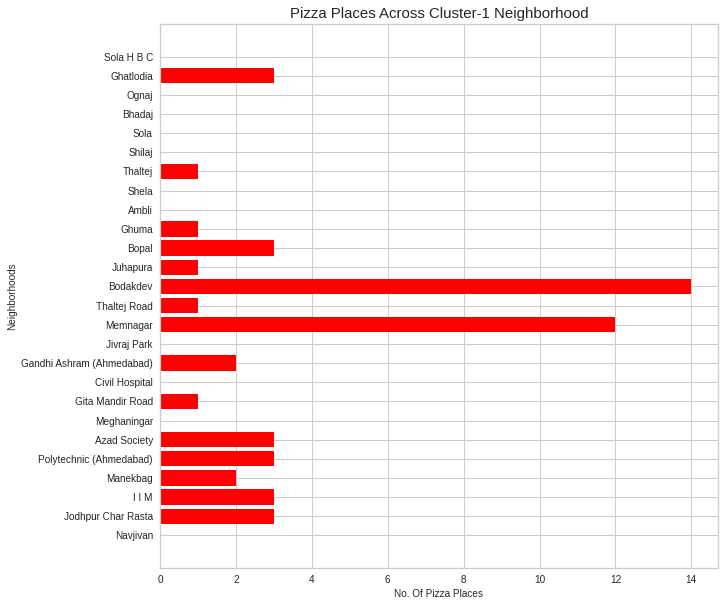

In [34]:
f, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 15})

plt.barh(cluster1_df.iloc[:,-2], cluster1_df.iloc[:,-1].values, color='red')
plt.title('Pizza Places Across Cluster-1 Neighborhood', fontsize=15)
plt.xlabel('No. Of Pizza Places', fontsize=10)
plt.ylabel('Neighborhoods', fontsize=10)

plt.show()

#### Cluster 2

In [35]:
cluster2_df = geo_df.loc[geo_df['Cluster Labels']==1, geo_df.columns[[2] + list(range(4, geo_df.shape[1]))]]
cluster2_df

,Neighborhood,Venue
0,Lal Darwaja,1
1,Manek Chowk,4
2,Shahibag,3


In [36]:
print('Total Neighborhoods in Cluster-2:', cluster2_df.shape[0])
cluster2_df['Venue'].mean()

Total Neighborhoods in Cluster-2: 3


2.6666666666666665

In [37]:
rp.summary_cont(cluster2_df['Venue'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Venue,3.0,2.6667,1.5275,0.8819,-1.1279,6.4612


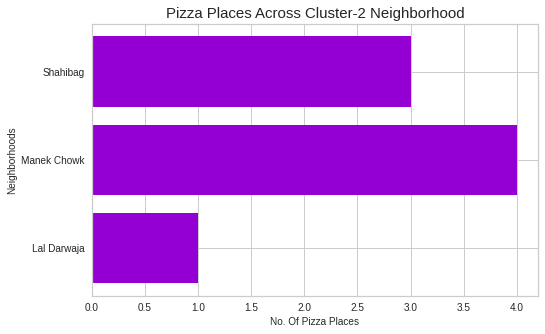

In [38]:
f, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 15})

plt.barh(cluster2_df.iloc[:,-2], cluster2_df.iloc[:,-1].values, color='darkviolet')
plt.title('Pizza Places Across Cluster-2 Neighborhood', fontsize=15)
plt.xlabel('No. Of Pizza Places', fontsize=10)
plt.ylabel('Neighborhoods', fontsize=10)

plt.show()

#### Cluster 3

In [39]:
cluster3_df = geo_df.loc[geo_df['Cluster Labels']==2, geo_df.columns[[2] + list(range(4, geo_df.shape[1]))]]
cluster3_df

,Neighborhood,Venue
8,Paldi (Ahmedabad),2
9,Sarkhej Road,0
10,Anandnagar (Ahmedabad),13
11,Shardanagar,3
12,Narayannagar,2
13,Jawahar Chowk,2
14,Maninagar,5
15,Ashram Road,3
16,Darpan Society,6
17,Gujarat University,6


In [40]:
print('Total Neighborhoods in Cluster-3:', cluster3_df.shape[0])
cluster3_df['Venue'].mean()

Total Neighborhoods in Cluster-3: 16


3.5

In [41]:
rp.summary_cont(cluster3_df['Venue'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Venue,16.0,3.5,3.559,0.8898,1.6035,5.3965


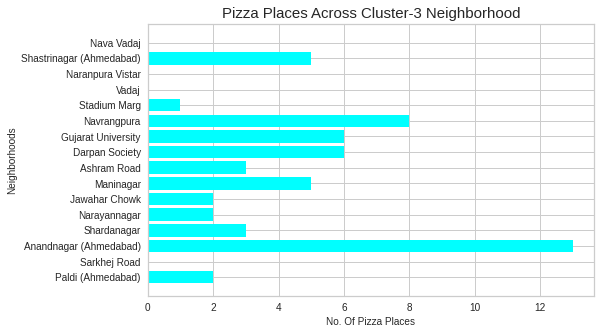

In [42]:
f, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 15})

plt.barh(cluster3_df.iloc[:,-2], cluster3_df.iloc[:,-1].values, color='cyan')
plt.title('Pizza Places Across Cluster-3 Neighborhood', fontsize=15)
plt.xlabel('No. Of Pizza Places', fontsize=10)
plt.ylabel('Neighborhoods', fontsize=10)

plt.show()

#### Cluster 4

In [43]:
cluster4_df = geo_df.loc[geo_df['Cluster Labels']==3, geo_df.columns[[2] + list(range(4, geo_df.shape[1]))]]
cluster4_df

,Neighborhood,Venue
3,Sabarmati,0
4,Kabir Chowk,0
5,Motera,1
6,Ambawadi (Ahmedabad),2
7,Ellisbridge,0


In [44]:
print('Total Neighborhoods in Cluster-4:', cluster4_df.shape[0])
cluster4_df['Venue'].mean()

Total Neighborhoods in Cluster-4: 5


0.6

In [45]:
rp.summary_cont(cluster4_df['Venue'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Venue,5.0,0.6,0.8944,0.4,-0.5106,1.7106


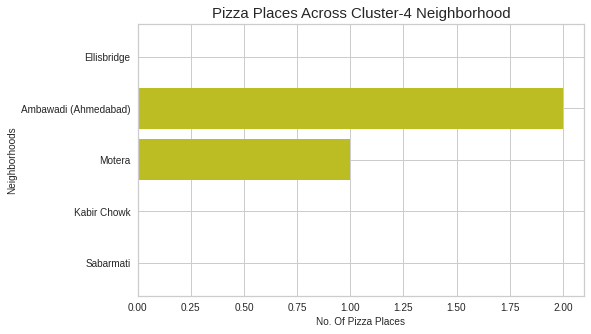

In [46]:
f, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 15})

plt.barh(cluster4_df.iloc[:,-2], cluster4_df.iloc[:,-1].values, color='tab:olive')
plt.title('Pizza Places Across Cluster-4 Neighborhood', fontsize=15)
plt.xlabel('No. Of Pizza Places', fontsize=10)
plt.ylabel('Neighborhoods', fontsize=10)

plt.show()

### Plot Pizza Places On The City Map

In [47]:
cluster4_geo = ahmedabad_venues[ahmedabad_venues['Neighborhood'].isin(cluster4_df.loc[:,'Neighborhood'].tolist())]
cluster4_geo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance
19,Ambawadi (Ahmedabad),23.022612,72.549083,4bd6e542cfa7b7131e3928da,Jasuben Pizza,23.020767,72.553965,Pizza Place,540
16,Motera,23.091703,72.597481,500ec373e4b0daa6102afcb5,The Pizza Hub,23.098003,72.598401,Pizza Place,707
17,Ambawadi (Ahmedabad),23.022612,72.549083,51892418498e9cfa3b39d1c4,Pizza Hut,23.021664,72.556783,Pizza Place,795


In [48]:
from folium import plugins
abad_map = folium.Map(location = [latitude, longitude], zoom_start = 11.5)

restaurants = plugins.MarkerCluster().add_to(abad_map)

for lat, lng, label in zip(cluster4_geo['Venue Latitude'], cluster4_geo['Venue Longitude'], cluster4_geo['Venue'] + ',' + cluster4_geo['Neighborhood']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=folium.Popup(label, parse_html=True)
    ).add_to(restaurants)

abad_map

In [49]:
cols = ['Cluster', 'Avg']
lst_places = [['Cluster 1', cluster1_df['Venue'].mean()],
              ['Cluster 2', cluster2_df['Venue'].mean()],
              ['Cluster 3', cluster3_df['Venue'].mean()],
              ['Cluster 4', cluster4_df['Venue'].mean()]]
avg_plc_df = pd.DataFrame(lst_places, columns=cols)
avg_plc_df

,Cluster,Avg
0,Cluster 1,2.038462
1,Cluster 2,2.666667
2,Cluster 3,3.500000
3,Cluster 4,0.600000


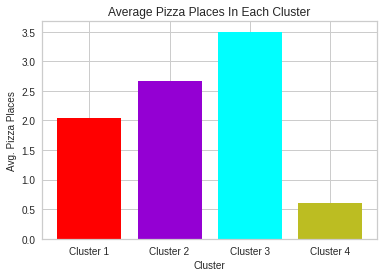

In [50]:
f, ax = plt.subplots(figsize=(6,4))
plt.rcParams.update({'font.size': 15})

plt.bar(avg_plc_df.iloc[:,-2], avg_plc_df.iloc[:,-1].values, color=['red','darkviolet','cyan', 'tab:olive'])
plt.title('Average Pizza Places In Each Cluster', fontsize=12)
plt.xlabel('Cluster', fontsize=10)
plt.ylabel('Avg. Pizza Places', fontsize=10)

plt.show()

In [51]:
import scipy.stats as stats

print('C1 - C4',stats.f_oneway(cluster1_df['Venue'], cluster4_df['Venue']))
print('C2 - C4',stats.f_oneway(cluster2_df['Venue'], cluster4_df['Venue']))
print('C3 - C4',stats.f_oneway(cluster3_df['Venue'], cluster4_df['Venue']))
print('C1..C4',stats.f_oneway(cluster1_df['Venue'], cluster2_df['Venue'],
                              cluster3_df['Venue'], cluster4_df['Venue']))

C1 - C4 F_onewayResult(statistic=0.8327928383664105, pvalue=0.3689907246453171)
C2 - C4 F_onewayResult(statistic=6.108050847457627, pvalue=0.04836272841112637)
C3 - C4 F_onewayResult(statistic=3.1507443557133015, pvalue=0.0919151363402473)
C1..C4 F_onewayResult(statistic=1.2089373788253346, pvalue=0.3171103994642223)


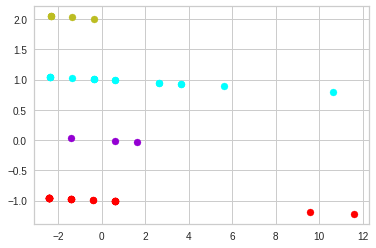

In [52]:
#PCA
from sklearn.decomposition import PCA
all_clusters = geo_df[['Cluster Labels','Venue']]

acp = PCA(n_components=2).fit_transform(all_clusters)

for colour,k in zip(['red','darkviolet','cyan','tab:olive'],[0,1,2,3]):
  plt.scatter(acp[kmeans.labels_==k,0],acp[kmeans.labels_==k,1],c=colour)
plt.show() 


In [53]:
high_density_nbr = geo_df.sort_values(by='Venue', ascending=False).head(10)
high_density_nbr

,V Lat,V Long,Neighborhood,Cluster Labels,Venue
37,23.044227,72.517458,Bodakdev,0,14
10,23.016075,72.509295,Anandnagar (Ahmedabad),2,13
35,23.053084,72.532931,Memnagar,0,12
18,23.036000,72.564343,Navrangpura,2,8
17,23.037307,72.544748,Gujarat University,2,6
16,23.046712,72.553567,Darpan Society,2,6
14,22.997713,72.606717,Maninagar,2,5
22,23.062423,72.553180,Shastrinagar (Ahmedabad),2,5
1,23.023180,72.588952,Manek Chowk,1,4
29,23.029157,72.532752,Azad Society,0,3


#### Define Function To Explore Neighborhood

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=1100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',           
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
all_venues = getNearbyVenues(
                                     names = high_density_nbr['Neighborhood'],
                                     latitudes = high_density_nbr['V Lat'],
                                     longitudes = high_density_nbr['V Long'],
                                 )
all_venues.head()

Bodakdev
Anandnagar (Ahmedabad)
Memnagar
Navrangpura
Gujarat University
Darpan Society
Maninagar
Shastrinagar (Ahmedabad)
Manek Chowk
Azad Society


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bodakdev,23.044227,72.517458,4ee0f40e7ee54945fe4de077,Apna Adda,23.043714,72.514701,Coffee Shop
1,Bodakdev,23.044227,72.517458,4c9f09eed3c2b60cbe35d1bc,PVR Cinemas,23.048943,72.516024,Multiplex
2,Bodakdev,23.044227,72.517458,4fcba949e4b0e33fd4f0eca5,Cravingz,23.048866,72.516107,Ice Cream Shop
3,Bodakdev,23.044227,72.517458,5247073b498e70435ef93e1a,Souq - bistro & grills,23.048991,72.515867,Mediterranean Restaurant
4,Bodakdev,23.044227,72.517458,4d4bddada22c224be8bdf393,Subway,23.048850,72.516126,Sandwich Place


In [56]:
all_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)

In [76]:
top_venues = pd.DataFrame(all_venues.groupby('Venue Category').count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
top_venues.reset_index(inplace=True)
top_venues = top_venues.head(10)
top_venues.rename(columns={'Neighborhood':'Venue count'}, inplace=True)
top_venues

,Venue Category,Venue count
0,Indian Restaurant,34
1,Café,33
2,Fast Food Restaurant,20
3,Pizza Place,13
4,Coffee Shop,12
5,Hotel,11
6,Sandwich Place,11
7,Restaurant,11
8,Vegetarian / Vegan Restaurant,8
9,Ice Cream Shop,8


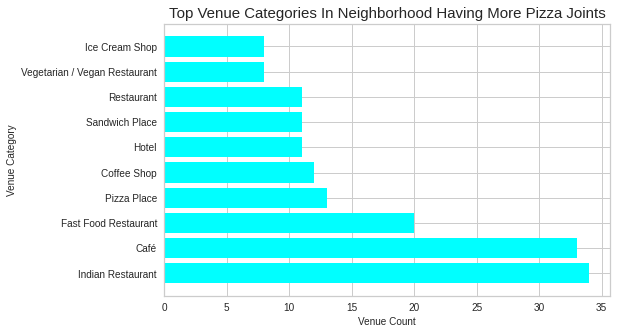

In [58]:
f, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 15})

plt.barh(top_venues.iloc[:,-2], top_venues.iloc[:,-1].values, color='cyan')
plt.title('Top Venue Categories In Neighborhood Having More Pizza Joints', fontsize=15)
plt.xlabel('Venue Count', fontsize=10)
plt.ylabel('Venue Category', fontsize=10)

plt.show()

#### Explore Cluster 4 Neighborhoods

In [59]:
cluster4_nbr = geo_df[geo_df['Cluster Labels']==3]
cluster4_nbr

,V Lat,V Long,Neighborhood,Cluster Labels,Venue
3,23.083993,72.587619,Sabarmati,3,0
4,23.087505,72.585701,Kabir Chowk,3,0
5,23.091703,72.597481,Motera,3,1
6,23.022612,72.549083,Ambawadi (Ahmedabad),3,2
7,23.022886,72.571642,Ellisbridge,3,0


In [60]:
c4_venues = getNearbyVenues(
                                     names = cluster4_nbr['Neighborhood'],
                                     latitudes = cluster4_nbr['V Lat'],
                                     longitudes = cluster4_nbr['V Long'],
                                 )
c4_venues.head()

Sabarmati
Kabir Chowk
Motera
Ambawadi (Ahmedabad)
Ellisbridge


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sabarmati,23.083993,72.587619,4ead38a86c250091a225e2cc,Maharaj Snacks,23.083980,72.589414,Fast Food Restaurant
1,Sabarmati,23.083993,72.587619,53f85285498e1ef0fdedd5a9,Shakti The Sandwich Shop,23.086158,72.588658,Sandwich Place
2,Sabarmati,23.083993,72.587619,502d3df9e4b0f9a2dc4baa84,River Front,23.086647,72.587283,River
3,Sabarmati,23.083993,72.587619,4e070364d22d658532a3685f,City Gold,23.088546,72.590189,Multiplex
4,Sabarmati,23.083993,72.587619,4dbea46eced7ea5898dce582,Sabarmati Railway Station,23.077659,72.588537,Train Station


In [61]:
c4_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)

In [62]:
c4_top_venues = pd.DataFrame(c4_venues.groupby('Venue Category').count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
c4_top_venues.reset_index(inplace=True)
c4_top_venues = c4_top_venues.head(10)
c4_top_venues

,Venue Category,Neighborhood
0,Café,13
1,Indian Restaurant,13
2,Fast Food Restaurant,9
3,Hotel,7
4,Shopping Mall,3
5,Sandwich Place,3
6,River,3
7,Restaurant,3
8,Pizza Place,3
9,Mexican Restaurant,3


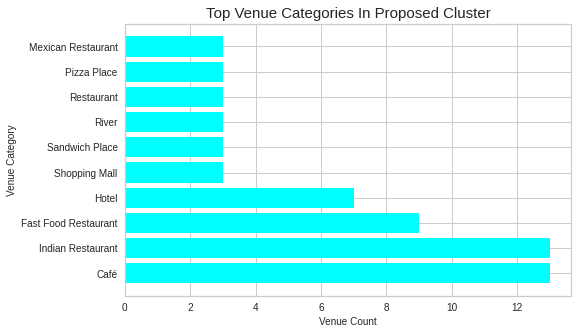

In [63]:
f, ax = plt.subplots(figsize=(8,5))
plt.rcParams.update({'font.size': 15})

plt.barh(c4_top_venues.iloc[:,-2], c4_top_venues.iloc[:,-1].values, color='cyan')
plt.title('Top Venue Categories In Proposed Cluster', fontsize=15)
plt.xlabel('Venue Count', fontsize=10)
plt.ylabel('Venue Category', fontsize=10)

plt.show()

#### Define Jaccard Similarity Score Function

In [118]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#### Let's Check the Similarity of the Neighborhoods Having Most Pizza Places With the Proposed Cluster

In [119]:
from sklearn.metrics import jaccard_score
# from sklearn.preprocessing import LabelEncoder

X1 = top_venues.iloc[:,0].values.tolist()
X2 = c4_top_venues.iloc[:,0].values.tolist()

# le = LabelEncoder()
# y = X1 + X2
# z = pd.DataFrame(le.fit_transform(y))
# y = pd.DataFrame(y)
# y = pd.concat([y, z], axis=1, ignore_index=True)

# print(y)
# X1 = y.iloc[0:10, -1].values
# print(X1)
# X2 = y.iloc[10:20, -1].values
# print(X2)
# jscore = jaccard_score(X1, X2, average='weighted')
jscore = jaccard_similarity(X1,X2)
print('The Jaccard Similarity Score With Cluster-4 is', jscore)

The Jaccard Similarity Score With Cluster-4 is 0.5384615384615384


#### Explore Cluster 1 Neighborhoods

In [65]:
cluster1_nbr = geo_df[geo_df['Cluster Labels']==0]
c1_venues = getNearbyVenues(
                                     names = cluster1_nbr['Neighborhood'],
                                     latitudes = cluster1_nbr['V Lat'],
                                     longitudes = cluster1_nbr['V Long'],
                                 )
c1_venues.head()
c1_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)
c1_top_venues = pd.DataFrame(c1_venues.groupby('Venue Category').count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
c1_top_venues.reset_index(inplace=True)

Navjivan
Jodhpur Char Rasta
I I M
Manekbag
Polytechnic (Ahmedabad)
Azad Society
Meghaningar
Gita Mandir Road
Civil Hospital
Gandhi Ashram (Ahmedabad)
Jivraj Park
Memnagar
Thaltej Road
Bodakdev
Juhapura
Bopal
Ghuma
Ambli
Shela
Thaltej
Shilaj
Sola
Bhadaj
Ognaj
Ghatlodia
Sola H B C


In [66]:
c1_top_venues = c1_top_venues.head(10)
c1_top_venues

,Venue Category,Neighborhood
0,Indian Restaurant,36
1,Café,32
2,Fast Food Restaurant,22
3,Pizza Place,18
4,Hotel,11
5,Shopping Mall,11
6,Restaurant,11
7,Coffee Shop,10
8,Ice Cream Shop,9
9,Sandwich Place,8


#### Calculate Jaccard Similarity Score For Neighborhoods With More Pizza Places and Cluster 1 Neighborhoods

In [120]:
from sklearn.metrics import jaccard_score

X1 = top_venues.iloc[:,0].values.tolist()
X2 = c1_top_venues.iloc[:,0].values.tolist()

# jscore = jaccard_score(X1, X2, average='weighted')
jscore = jaccard_similarity(X1,X2)
print('The Jaccard Similarity Score With Cluster-1 is', jscore)

The Jaccard Similarity Score With Cluster-1 is 0.8181818181818182


#### Explore Cluster 2 Neighborhoods

In [68]:
cluster2_nbr = geo_df[geo_df['Cluster Labels']==1]
c2_venues = getNearbyVenues(
                                     names = cluster2_nbr['Neighborhood'],
                                     latitudes = cluster2_nbr['V Lat'],
                                     longitudes = cluster2_nbr['V Long'],
                                 )
c2_venues.head()
c2_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)
c2_top_venues = pd.DataFrame(c2_venues.groupby('Venue Category').count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
c2_top_venues.reset_index(inplace=True)

Lal Darwaja
Manek Chowk
Shahibag


In [69]:
c2_top_venues = c2_top_venues.head(10)
c2_top_venues

,Venue Category,Neighborhood
0,Indian Restaurant,8
1,Hotel,6
2,Historic Site,3
3,Tea Room,2
4,River,2
5,Bus Station,2
6,Museum,1
7,Track Stadium,1
8,Snack Place,1
9,Restaurant,1


#### Calculate Jaccard Similarity Score For Neighborhoods With More Pizza Places and Cluster 2 Neighborhoods

In [121]:
from sklearn.metrics import jaccard_score

X1 = top_venues.iloc[:,0].values.tolist()
X2 = c2_top_venues.iloc[:,0].values.tolist()

# jscore = jaccard_score(X1, X2, average='weighted')
jscore = jaccard_similarity(X1,X2)
print('The Jaccard Similarity Score With Cluster-2 is', jscore)

The Jaccard Similarity Score With Cluster-2 is 0.17647058823529413


#### Explore Cluster 3 Neighborhoods

In [71]:
cluster3_nbr = geo_df[geo_df['Cluster Labels']==2]
c3_venues = getNearbyVenues(
                                     names = cluster3_nbr['Neighborhood'],
                                     latitudes = cluster3_nbr['V Lat'],
                                     longitudes = cluster3_nbr['V Long'],
                                 )
c3_venues.head()
c3_venues.drop_duplicates(subset=['Venue ID'], keep='first', inplace=True)
c3_top_venues = pd.DataFrame(c3_venues.groupby('Venue Category').count()['Neighborhood']).sort_values(by='Neighborhood', ascending=False)
c3_top_venues.reset_index(inplace=True)

Paldi (Ahmedabad)
Sarkhej Road
Anandnagar (Ahmedabad)
Shardanagar
Narayannagar
Jawahar Chowk
Maninagar
Ashram Road
Darpan Society
Gujarat University
Navrangpura
Stadium Marg
Vadaj
Naranpura Vistar
Shastrinagar (Ahmedabad)
Nava Vadaj


In [72]:
c3_top_venues = c3_top_venues.head(10)
c3_top_venues

,Venue Category,Neighborhood
0,Indian Restaurant,34
1,Café,27
2,Fast Food Restaurant,20
3,Hotel,18
4,Pizza Place,13
5,Coffee Shop,11
6,Sandwich Place,9
7,Ice Cream Shop,8
8,Tea Room,8
9,Vegetarian / Vegan Restaurant,7


#### Calculate Jaccard Similarity Score For Neighborhoods With More Pizza Places and Cluster 3 Neighborhoods

In [123]:
from sklearn.metrics import jaccard_score

X1 = top_venues.iloc[:,0].values.tolist()
X2 = c3_top_venues.iloc[:,0].values.tolist()

# jscore = jaccard_score(X1, X2, average='weighted')
jscore = jaccard_similarity(X1,X2)
jscore

0.8181818181818182